# Advanced DL and RL: Домашнее задание 1



## Часть первая, с блекджеком и стратегиями

In [60]:
import itertools
import types

from gym import envs
from gym import spaces

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (12,6)
legend_fontsize = 14

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [61]:
env = envs.make("Blackjack-v0", natural=True)

### 1. Monte-carlo

In [62]:
def run_experiment(env):
    state = env.reset()
    if state[0] < 19:
        state = env.step(1)
        while state[0][0] < 19:
            state = env.step(1)
    state = env.step(0)
    return state[1]

Text(0, 0.5, 'Reward')

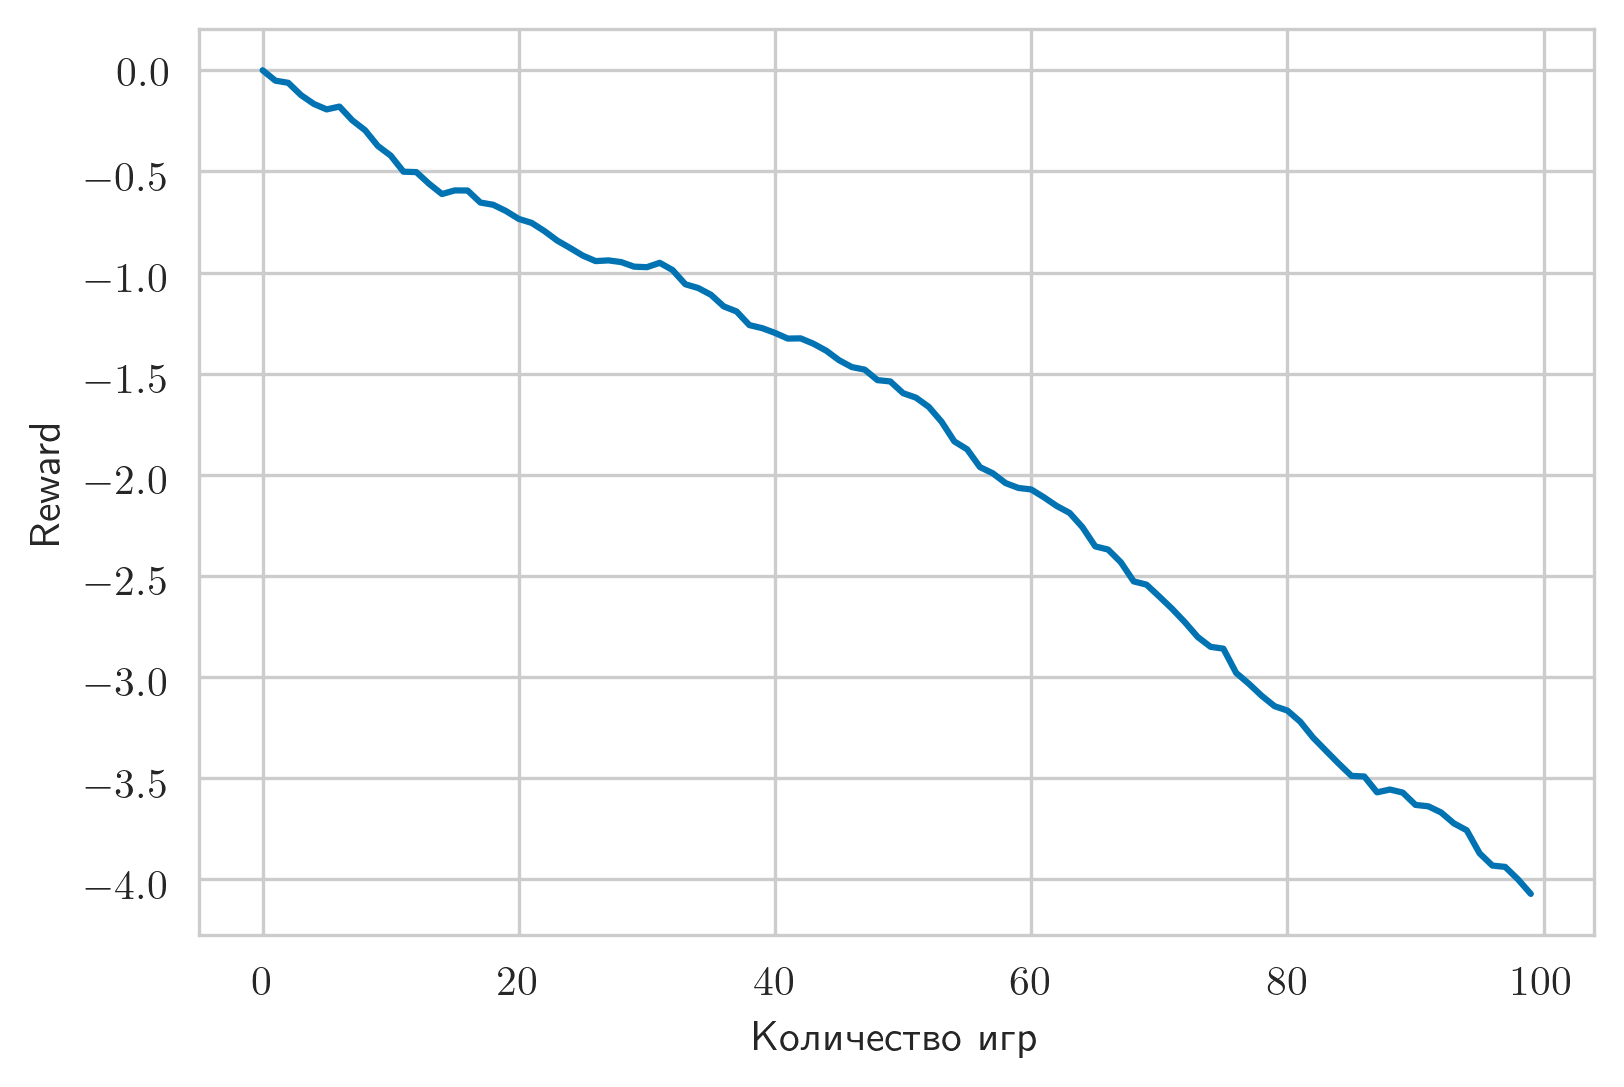

In [63]:
monte_carlo_runs = 1000
num_steps = 100
total_rewards = []
for _ in range(monte_carlo_runs):
    total_reward = [0]
    for _ in range(num_steps - 1):
        total_reward.append(total_reward[-1] + run_experiment(env))
    total_rewards.append(total_reward)

plt.plot(range(num_steps), np.mean(total_rewards, axis=0))
plt.xlabel('Количество игр')
plt.ylabel('Reward')

### 2. RL

#### Q-learning

In [64]:
MIN_PLAYER_SUM, MAX_PLAYER_SUM = 2, 21
MAX_DEALER_SUM = 10
states = list(itertools.product(range(2, MAX_PLAYER_SUM + 1), range(1, MAX_DEALER_SUM + 1), [True, False]))
state2num = dict(zip(states, range(len(states))))
nS  = len(states)
nA = env.action_space.n

In [65]:
def get_random_Q():
    Q = np.random.rand(nS, nA)
    return Q


def compute_policy_by_Q(Q):
    return np.argmax(Q, axis=1)


def Q_learning_episodes(env, num_episodes, alpha=0.05, epsilon=0.0, gamma=0.9, state_len=3):
    def get_s_a(state):
        s2n = state2num[state[:state_len]]
        s, a = s2n, pi[s2n] if np.random.rand() > epsilon else np.random.randint(nA)
        return s, a

    def init(env):
        state = env.reset()
        return get_s_a(state)

    rewards = []
    Q = get_random_Q()
    pi = compute_policy_by_Q(Q)
    
    for _ in range(num_episodes):
        s, a = init(env)
        while True:
            state, reward, done, info = env.step(a)
            if done:
                Q[s][a] = (1 - alpha) * Q[s][a] + alpha * reward
                rewards.append(reward)
            else:
                s_prime, a_prime = get_s_a(state)
                Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
                s, a = s_prime, a_prime
            pi = compute_policy_by_Q(Q)
            if done:
                s, a = init(env)
                break
    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1), Q

In [67]:
gamma = 0.1
alpha = 0.1
epsilon = 0.1
num_episodes = 500000

rewards, Q = Q_learning_episodes(env, num_episodes, 
                              alpha=alpha, epsilon=epsilon, gamma=gamma)

Text(0.5, 0, 'Количество игр')

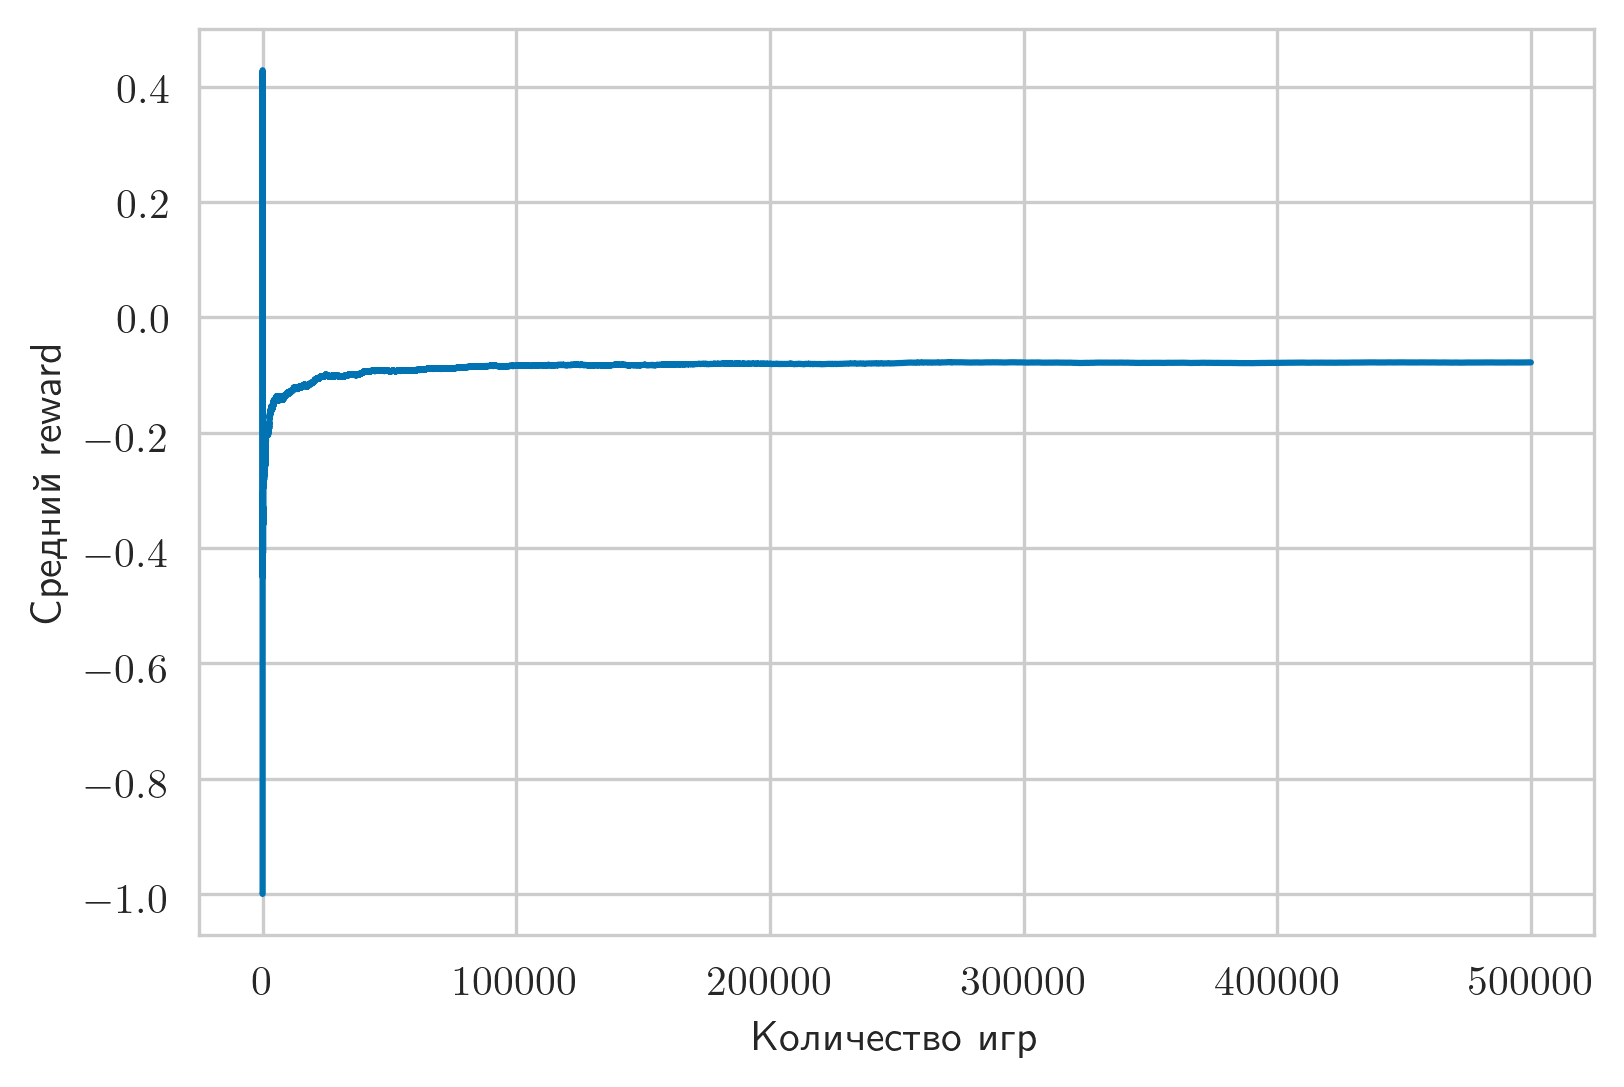

In [68]:
plt.plot(rewards)
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

Text(0.5, 0, 'Количество игр')

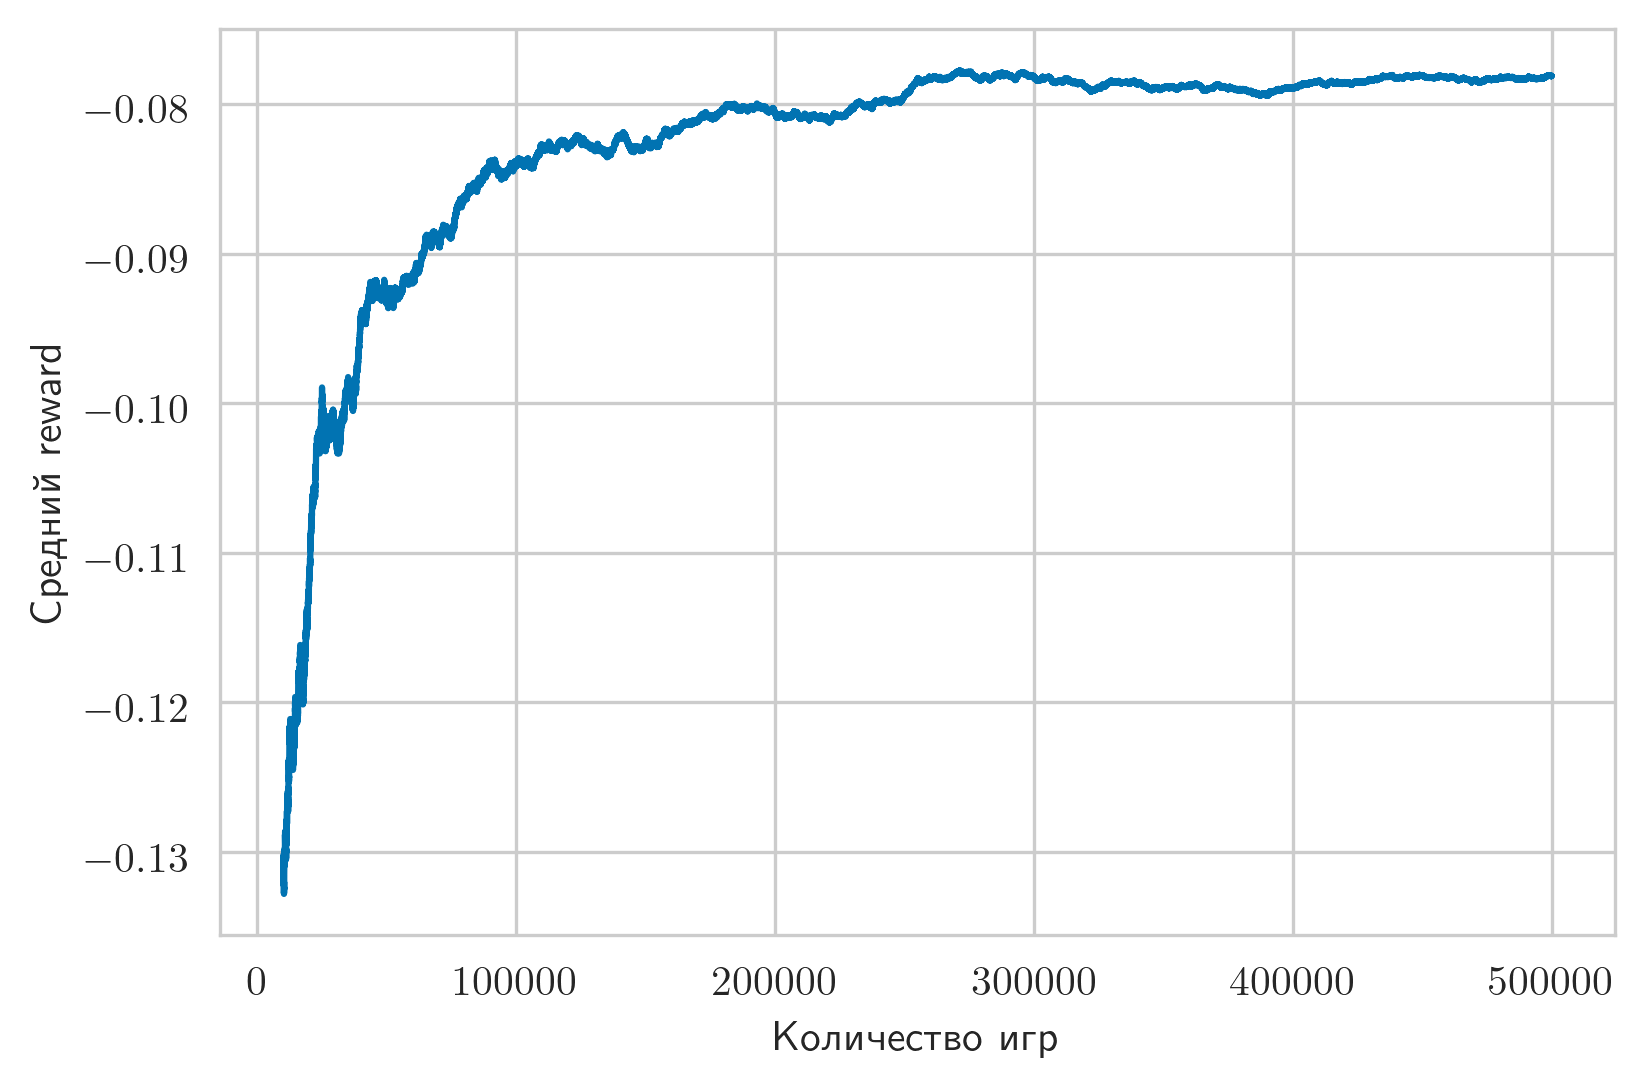

In [69]:
offset = 10000
plt.plot(range(offset, len(rewards)), rewards[offset:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

#### Стратегия без epsilon

In [70]:
def run_best_Q_strategy(env, Q, num_episodes, state_len=3):
    def get_s_a(state):
        s2n = state2num[state[:state_len]]
        s, a = s2n, pi[s2n]
        return s, a

    def init(env):
        state = env.reset()
        return get_s_a(state)
    
    rewards = []
    pi = compute_policy_by_Q(Q)
    
    for _ in range(num_episodes):
        _, a = init(env)
        while True:
            state, reward, done, info = env.step(a)
            if done:
                rewards.append(reward)
                s, a = init(env)
                break
            else:
                _, a = get_s_a(state)
    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1), Q

Text(0.5, 0, 'Количество игр')

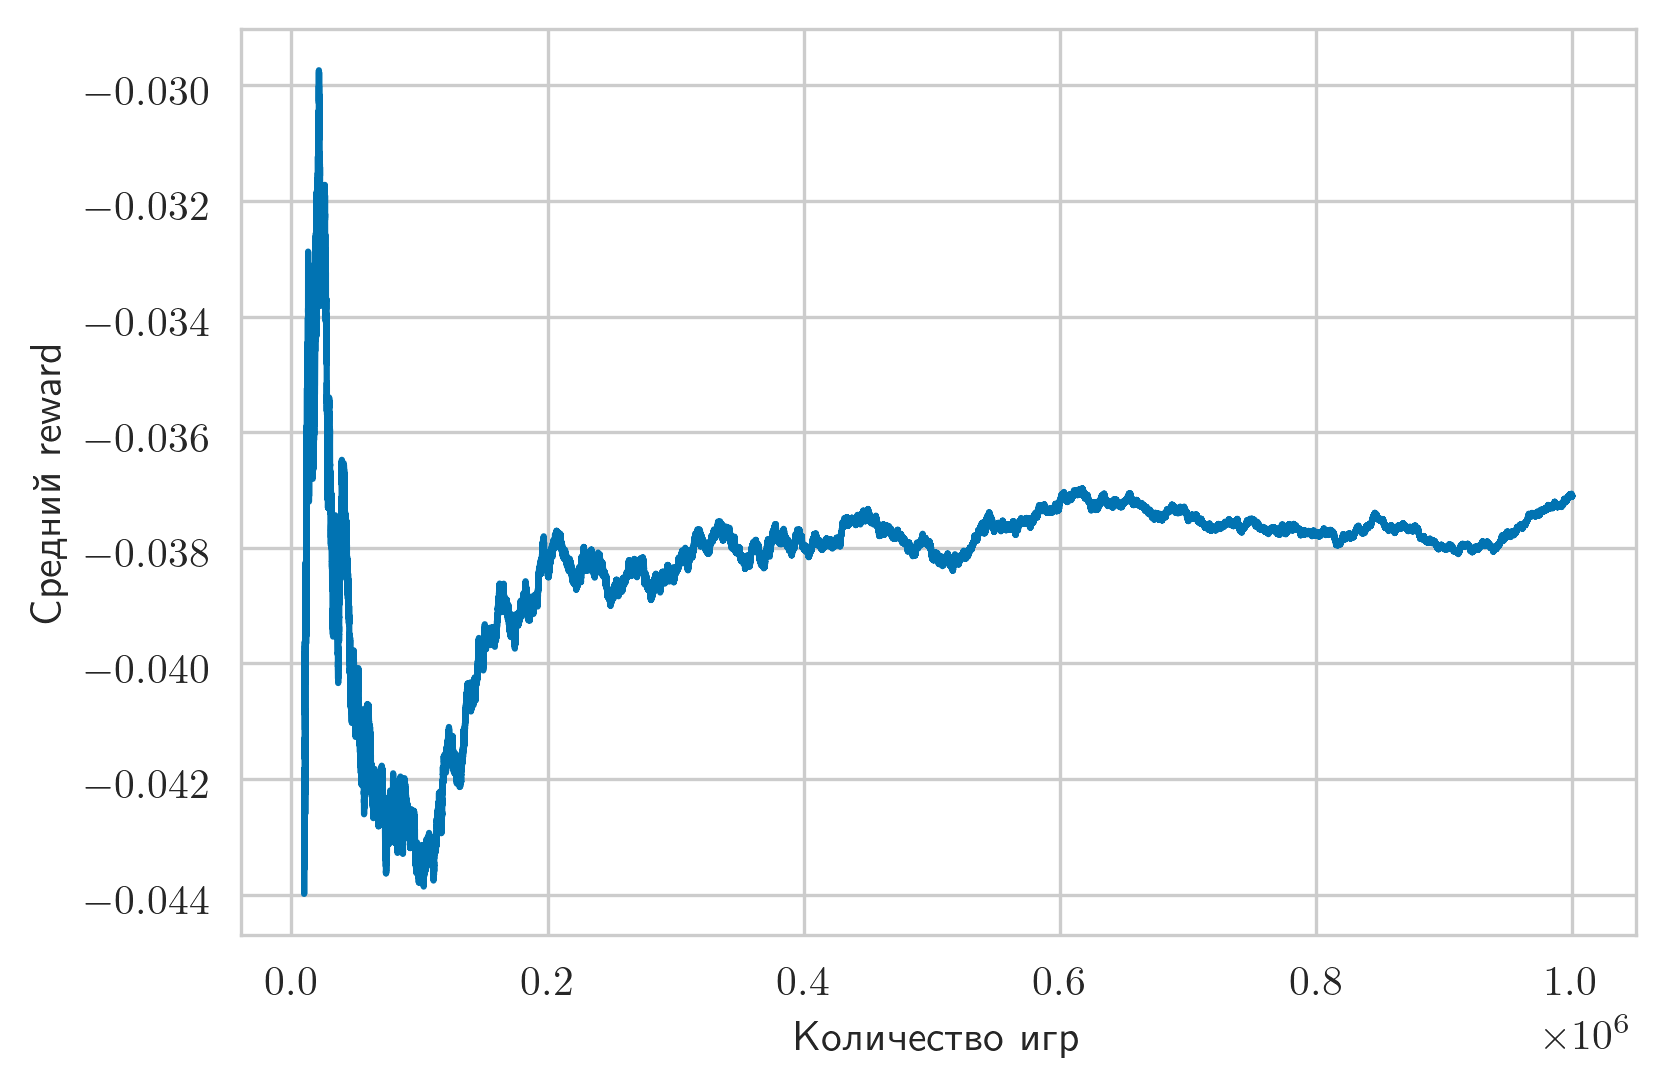

In [71]:
num_episodes = 1000000
best_Q_strategy_rewards_1, _ = run_best_Q_strategy(env, Q, num_episodes)
plt.plot(range(10000, len(best_Q_strategy_rewards_1)), best_Q_strategy_rewards_1[10000:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

### 3 Grid search

In [19]:
gammas = [0.1, 0.5, 0.9]
alphas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.5, 0.9]
num_episodes = 100000

grid_rewards = {}
for gamma in gammas:
    for alpha in alphas:
        for epsilon in epsilons:
            rewards, Q = Q_learning_episodes(env, num_episodes, 
                                          alpha=alpha, 
                                          epsilon=epsilon,
                                          gamma=gamma)
            grid_rewards[(gamma, alpha, epsilon)] = rewards

Text(0.5, 0, 'Количество игр')

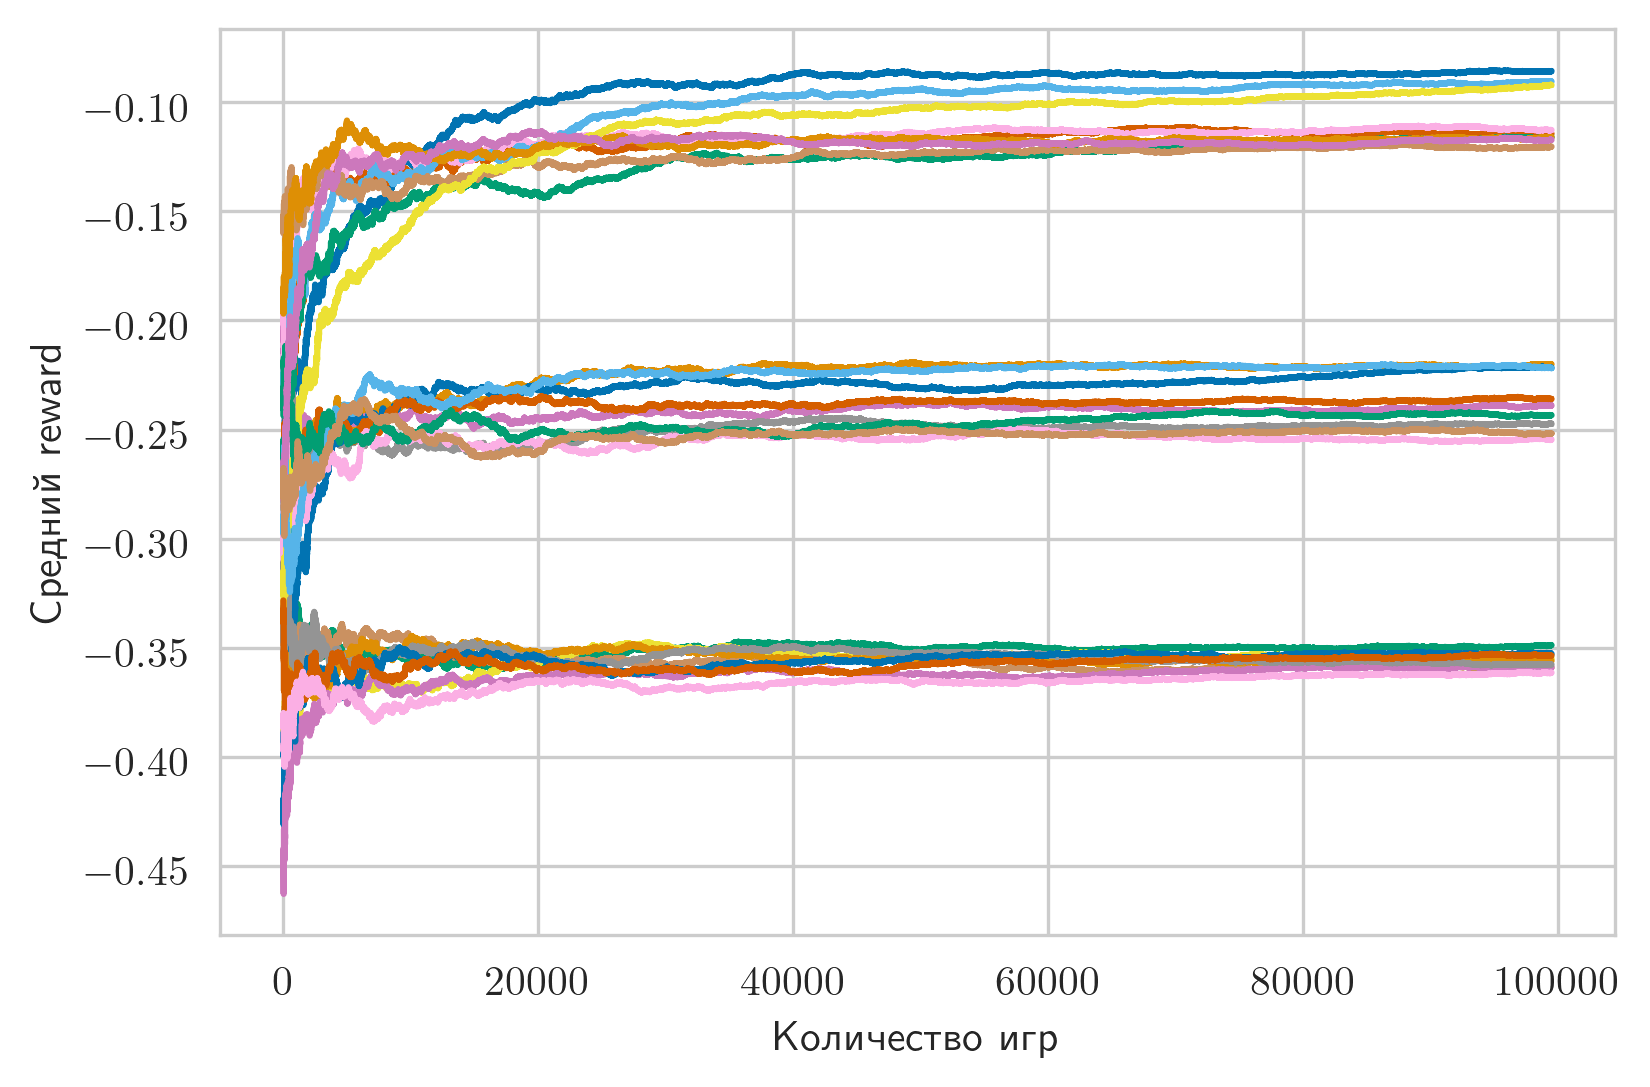

In [20]:
for gamma in gammas:
    for alpha in alphas:
        for epsilon in epsilons:
            plt.plot(grid_rewards[(gamma, alpha, epsilon)][500:],
                     label=f"gamma {gamma}, alpha {alpha}, epsilon {epsilon}")
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

#### Epsilon

Text(0.5, 0, 'Количество игр')

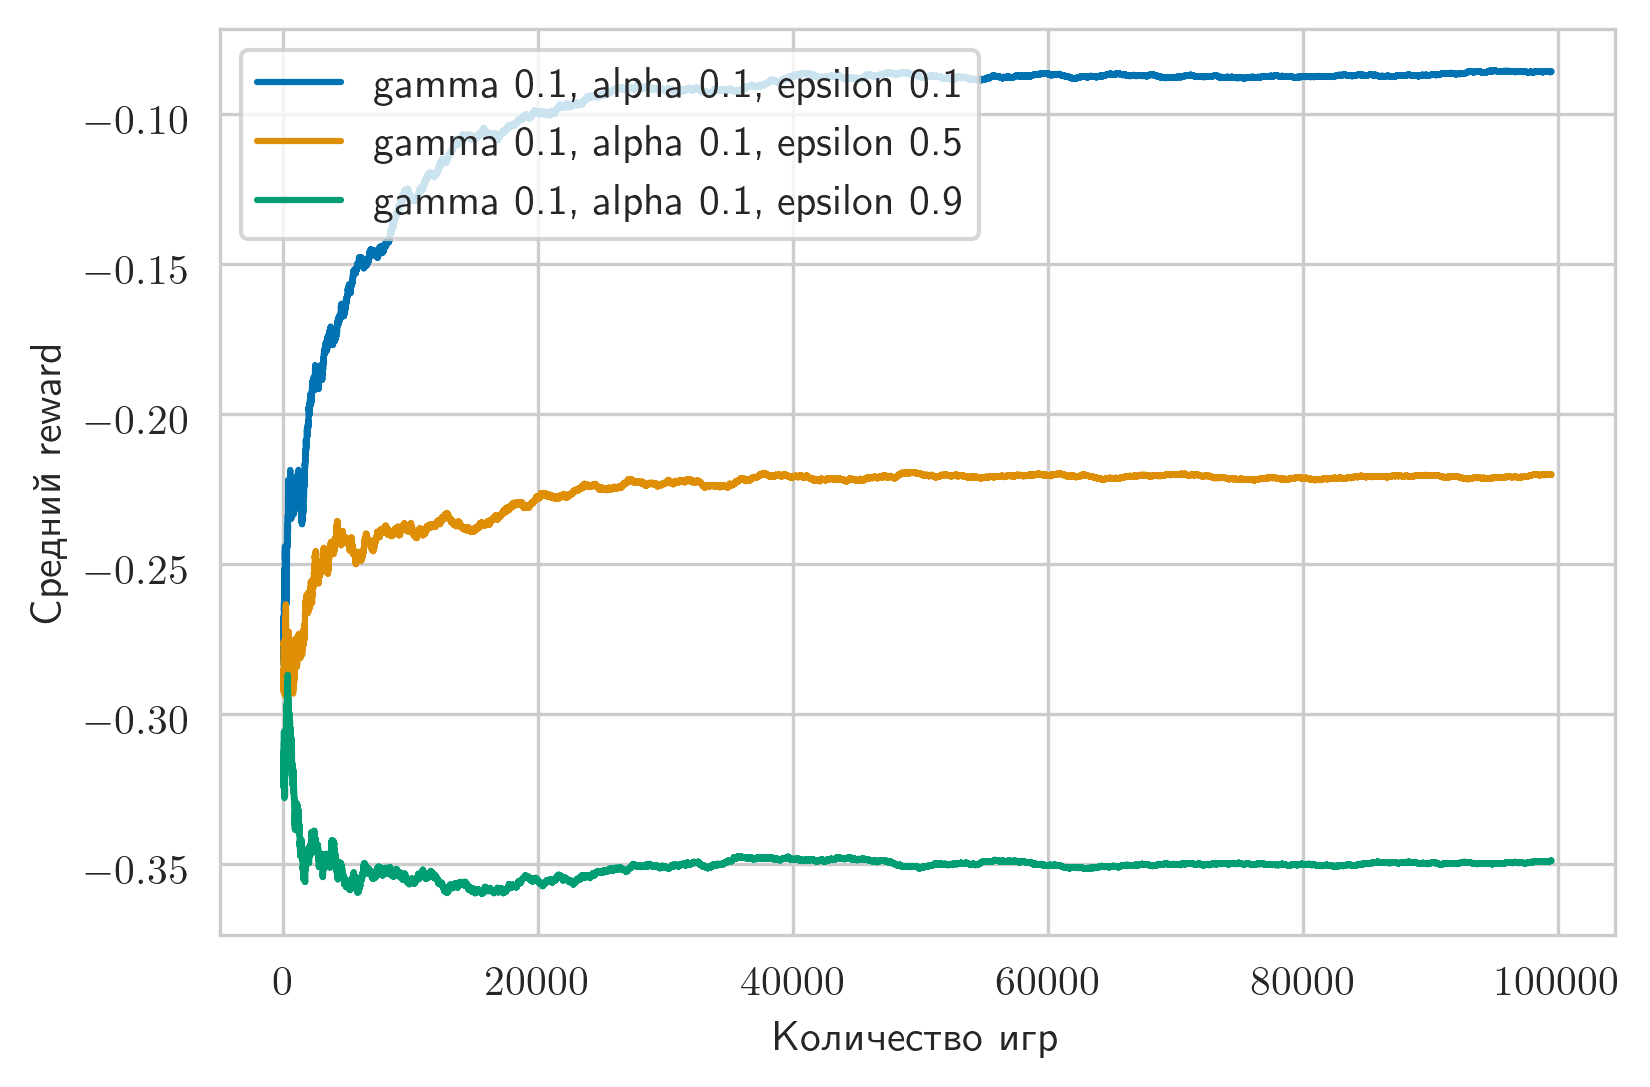

In [21]:
for gamma in gammas[:1]:
    for alpha in alphas[:1]:
        for epsilon in epsilons:
            plt.plot(grid_rewards[(gamma, alpha, epsilon)][500:],
                     label=f"gamma {gamma}, alpha {alpha}, epsilon {epsilon}")
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

#### Alpha

Text(0.5, 0, 'Количество игр')

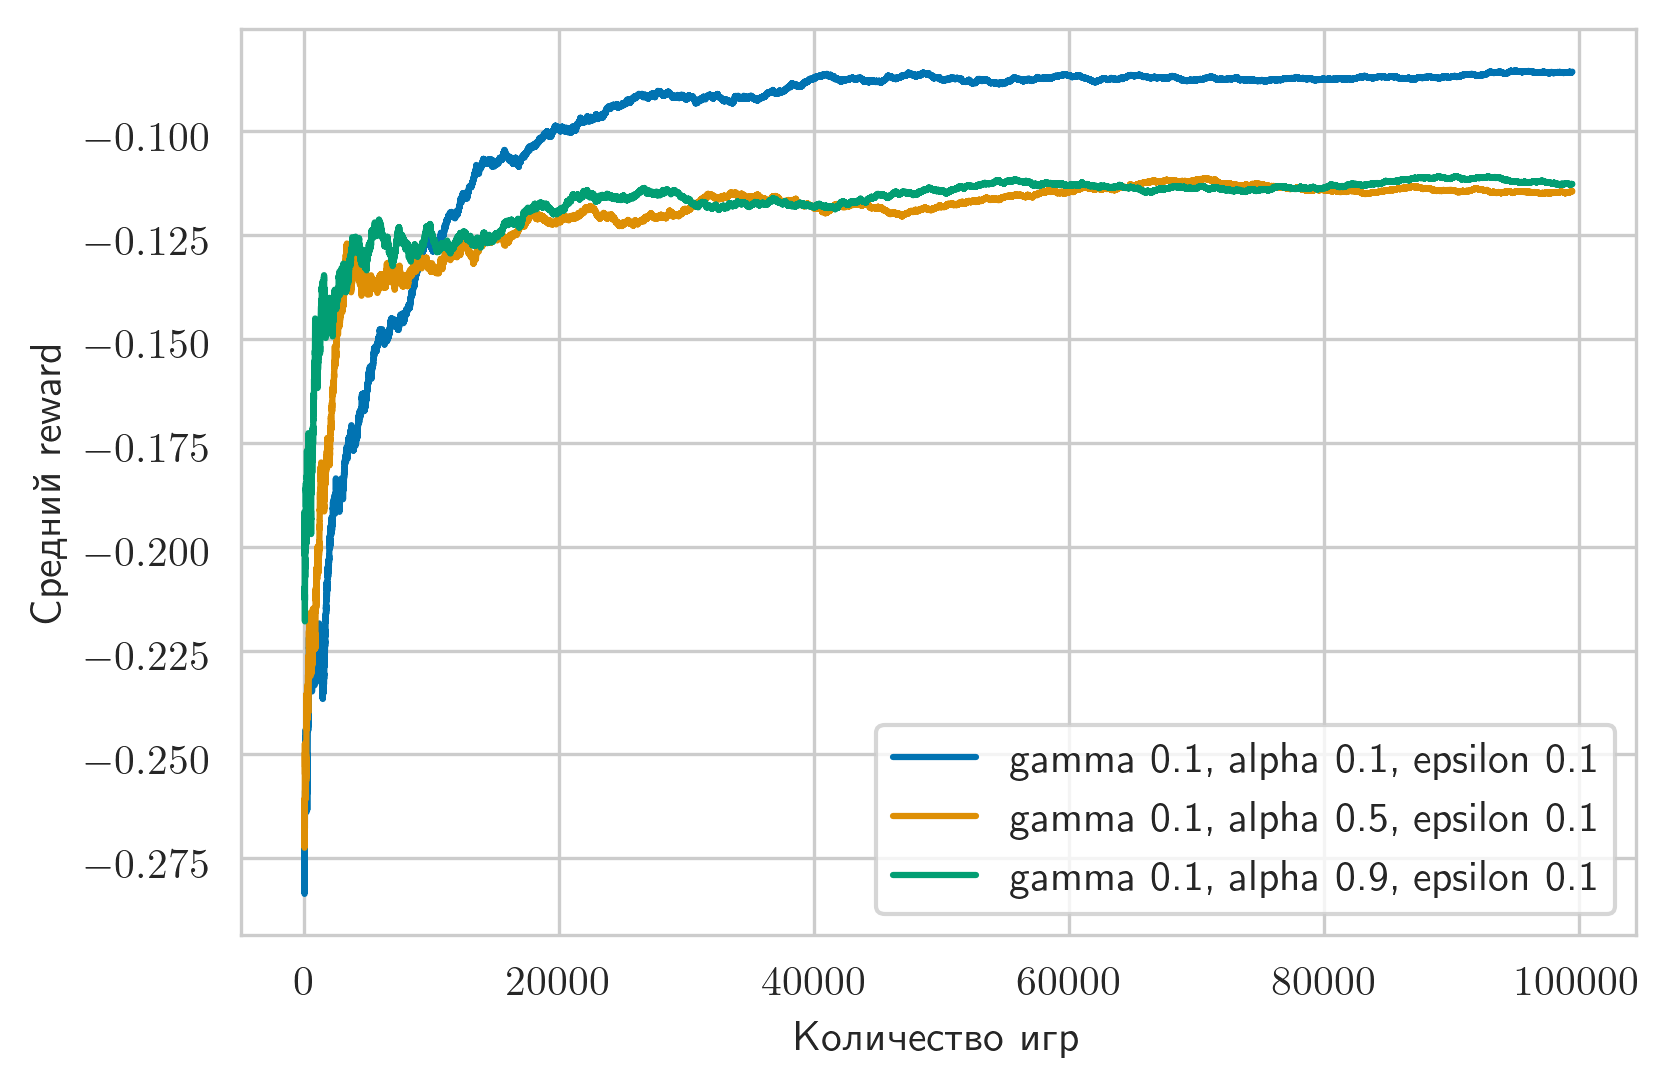

In [22]:
for gamma in gammas[:1]:
    for alpha in alphas:
        for epsilon in epsilons[:1]:
            plt.plot(grid_rewards[(gamma, alpha, epsilon)][500:],
                     label=f"gamma {gamma}, alpha {alpha}, epsilon {epsilon}")
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

#### Gamma

Text(0.5, 0, 'Количество игр')

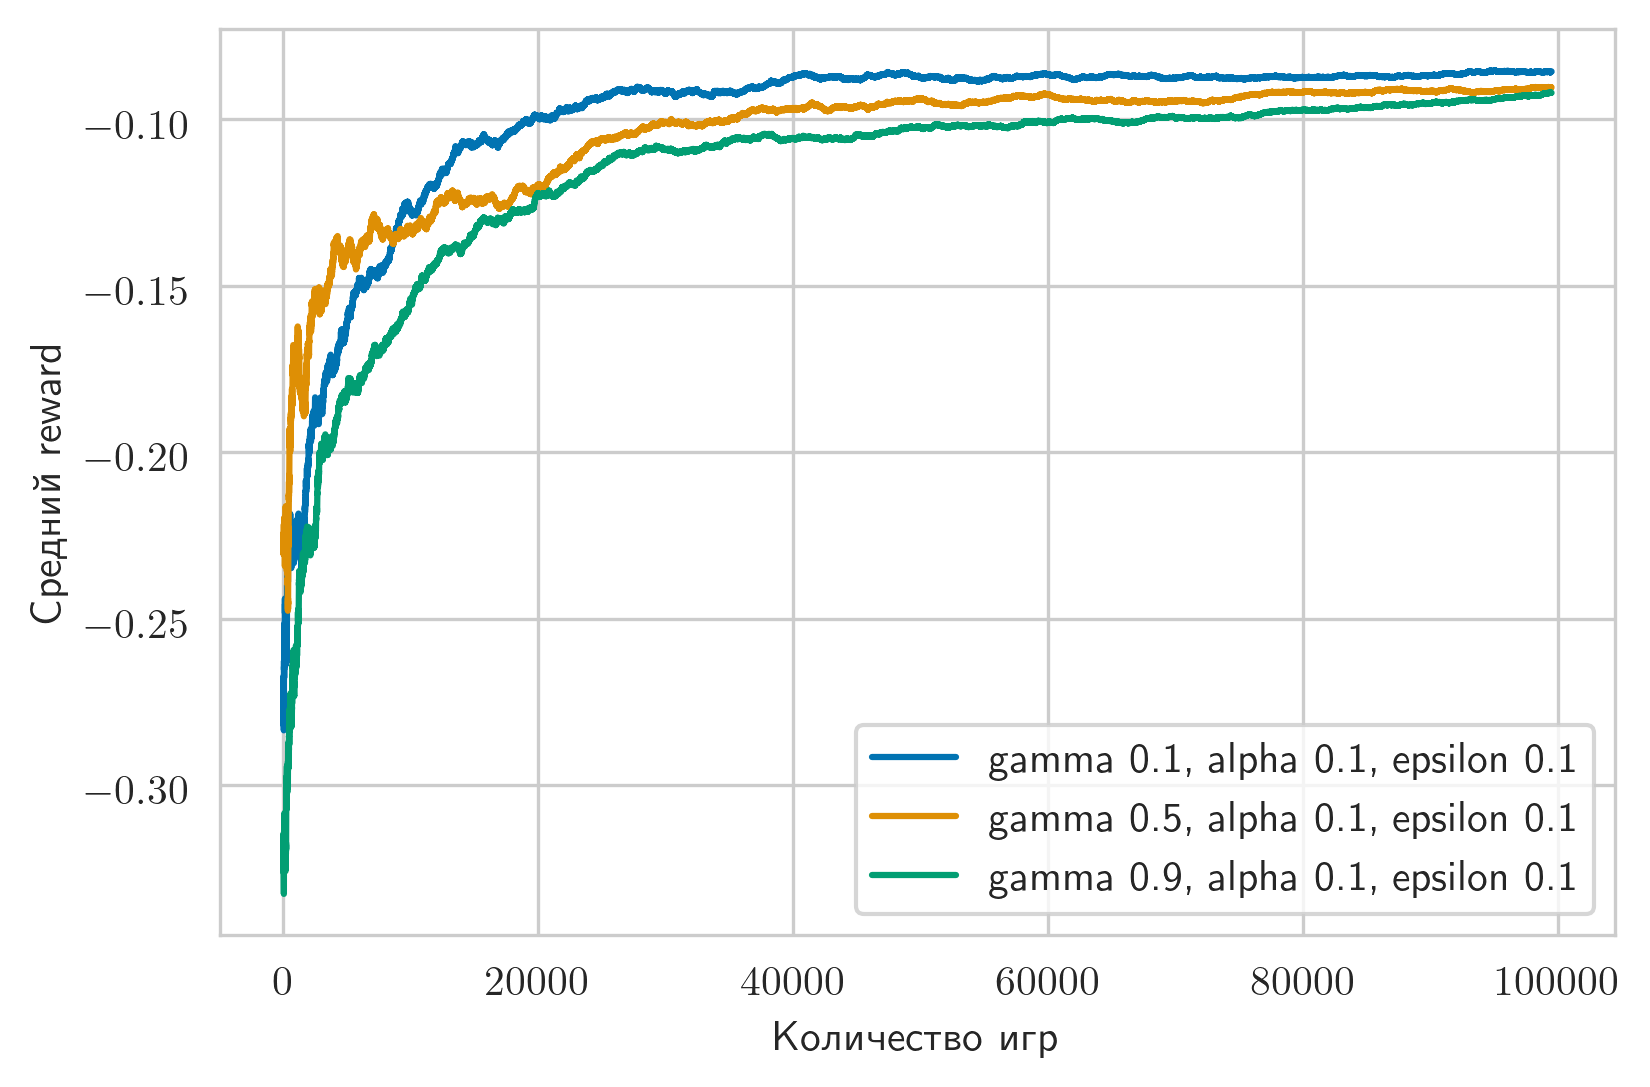

In [23]:
for gamma in gammas:
    for alpha in alphas[:1]:
        for epsilon in epsilons[:1]:
            plt.plot(grid_rewards[(gamma, alpha, epsilon)][500:],
                     label=f"gamma {gamma}, alpha {alpha}, epsilon {epsilon}")
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

## Часть вторая, удвоенная

In [39]:
env = envs.make("Blackjack-v0", natural=True)

deck =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def cmp(a, b):
    return float(a > b) - float(a < b)


def draw_card(np_random):
    return int(np_random.choice(deck))


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: # double: reward x2 and done = True
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):    
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if reward == 1:
                    reward = 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5            
        return self._get_obs(), reward, done, {}


env.action_space = spaces.Discrete(3)
env.step = types.MethodType(step, env)

In [40]:
MIN_PLAYER_SUM, MAX_PLAYER_SUM = 3, 21
MAX_DEALER_SUM = 10
states = list(itertools.product(range(2, MAX_PLAYER_SUM + 1), range(1, MAX_DEALER_SUM + 1), [True, False]))
state2num = dict(zip(states, range(len(states))))
nS  = len(states)
nA = env.action_space.n

In [41]:
gamma = 0.1
alpha = 0.1
epsilon = 0.1
num_episodes = 500000

rewards, Q = Q_learning_episodes(env, num_episodes, 
                                 alpha=alpha, epsilon=epsilon, gamma=gamma)

Text(0.5, 0, 'Количество игр')

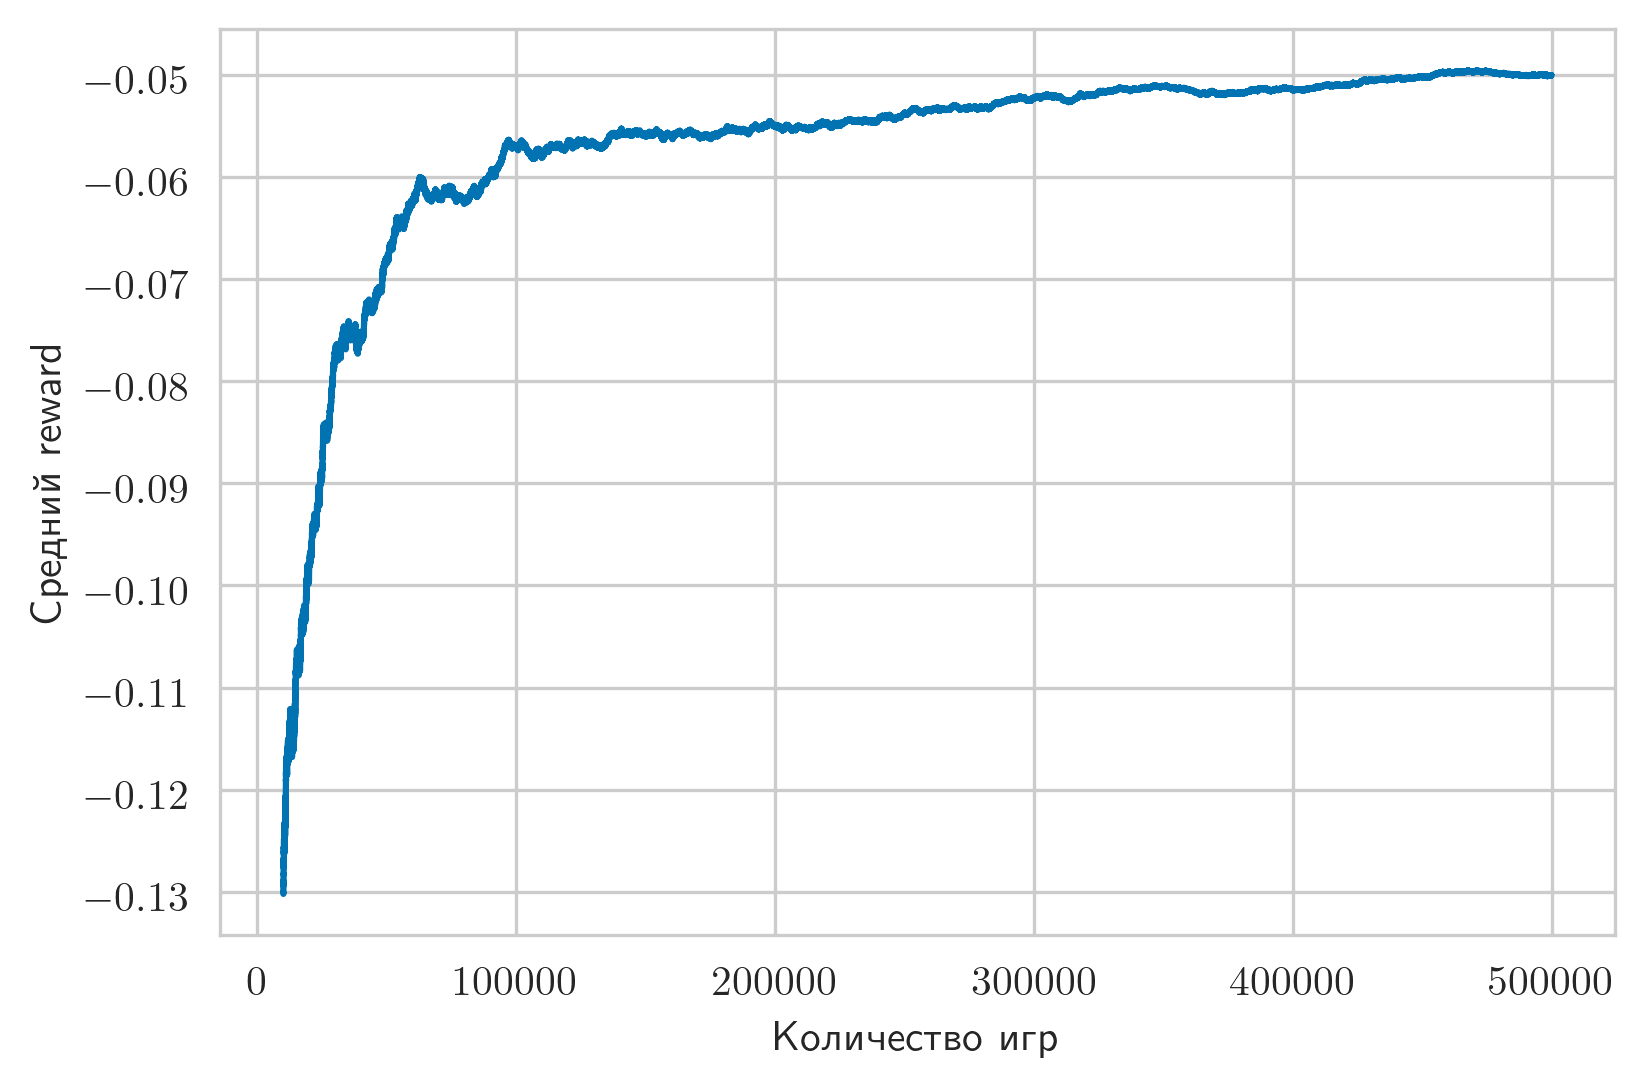

In [43]:
offset = 10000
plt.plot(range(offset, len(rewards)), rewards[offset:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

#### Стратегия с double без epsilon

Text(0.5, 0, 'Количество игр')

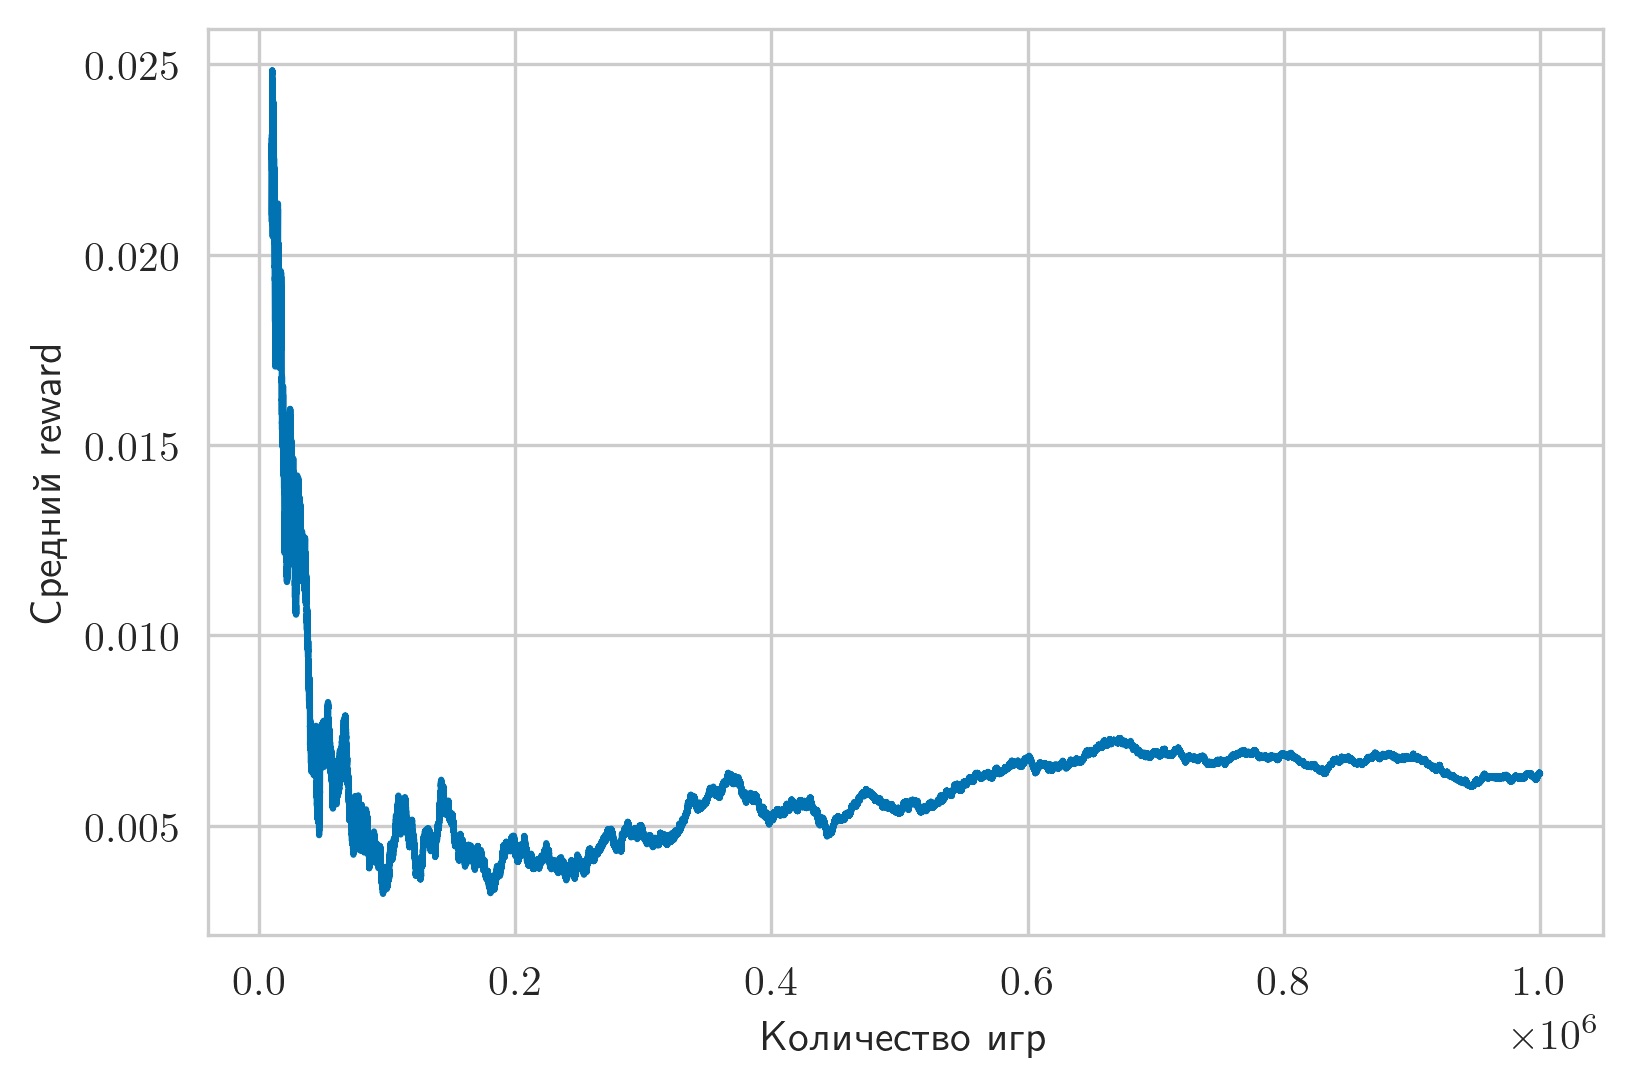

In [46]:
num_episodes = 1000000
best_Q_strategy_rewards_2, _ = run_best_Q_strategy(env, Q, num_episodes)
plt.plot(range(10000, len(best_Q_strategy_rewards_2)), best_Q_strategy_rewards_2[10000:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

## Часть третья, в главной роли — Дастин Хоффман

Бедем считать количество вышедших из колоды десяток (10, В, Д, К, Т) 

In [50]:
env = envs.make("Blackjack-v0", natural=True)


def init_deck(self):
    self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
    self.removed_deck = []

    
def draw_card(self, np_random):
    card = int(np_random.choice(self.deck))
    self.deck.remove(card)
    self.removed_deck.append(card)
    if len(self.deck) < 15:
        self.init_deck()
    return card

    
def draw_hand(self, np_random):
    return [self.draw_card(np_random), self.draw_card(np_random)]


def reset(self):
    self.dealer = self.draw_hand(self.np_random)
    self.player = self.draw_hand(self.np_random)
    return self._get_obs()


def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), 
                sum(1 for x in self.removed_deck if x in [1, 10]))

    
def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: # double: reward x2 and done = True
            self.player.append(self.draw_card(self.np_random))
            done = True
            if is_bust(self.player):    
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if reward == 1:
                    reward = 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5            
        return self._get_obs(), reward, done, {}


env.init_deck = types.MethodType(init_deck, env)
env.init_deck()
env.action_space = spaces.Discrete(3)
env.draw_card = types.MethodType(draw_card, env)
env.draw_hand = types.MethodType(draw_hand, env)
env.step = types.MethodType(step, env)
env.reset = types.MethodType(reset, env)
env._get_obs = types.MethodType(_get_obs, env)

In [52]:
MIN_PLAYER_SUM, MAX_PLAYER_SUM = 3, 21
MAX_DEALER_SUM = 10
states = list(itertools.product(range(2, MAX_PLAYER_SUM + 1), range(1, MAX_DEALER_SUM + 1), 
                                [True, False], range(21)))
state2num = dict(zip(states, range(len(states))))
nS  = len(states)
nA = env.action_space.n
print("States count:", len(states))

States count: 8400


In [53]:
gamma = 0.3
alpha = 0.1
epsilon = 0.4
num_episodes = 1000000

rewards, Q = Q_learning_episodes(env, num_episodes, 
                                 alpha=alpha, epsilon=epsilon, gamma=gamma, state_len=4)

Text(0.5, 0, 'Количество игр')

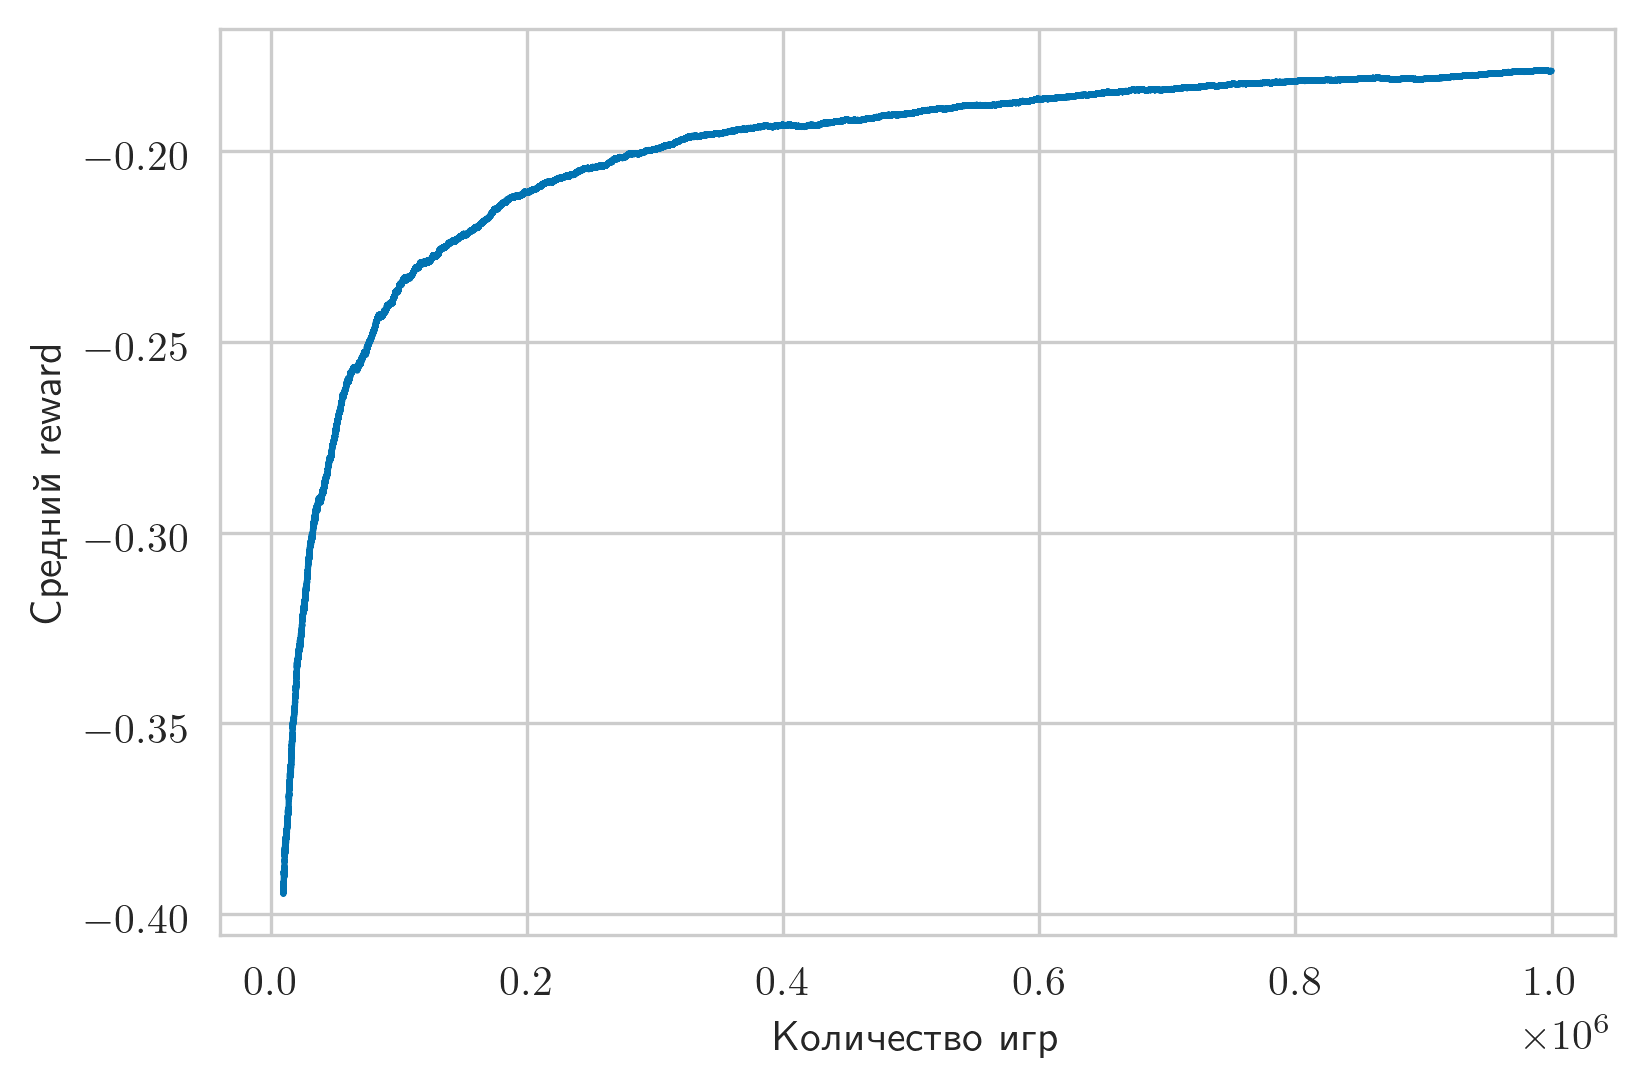

In [54]:
offset = 10000
plt.plot(range(offset, len(rewards)), rewards[offset:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

Text(0.5, 0, 'Количество игр')

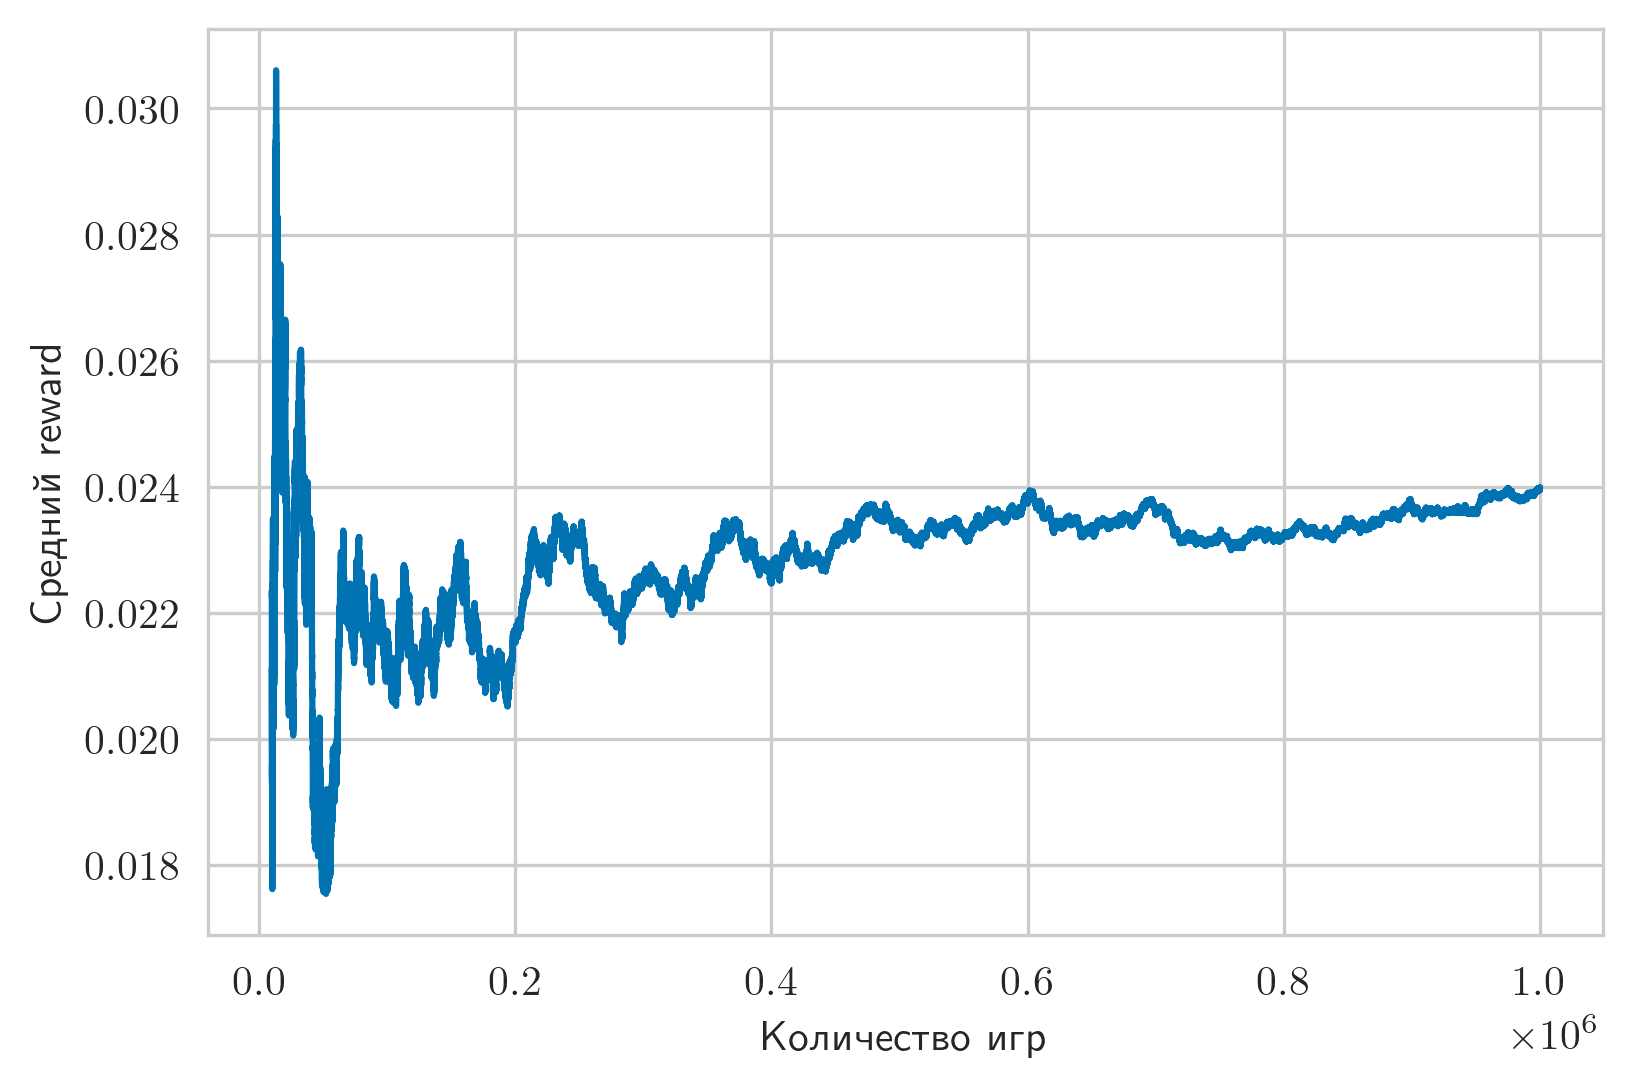

In [56]:
num_episodes = 1000000
best_Q_strategy_rewards_3, _ = run_best_Q_strategy(env, Q, num_episodes, state_len=4)
plt.plot(range(10000, len(best_Q_strategy_rewards_3)), best_Q_strategy_rewards_3[10000:])
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")

 **Сравним 3 модели (gym, double, double + подсчет карт)**

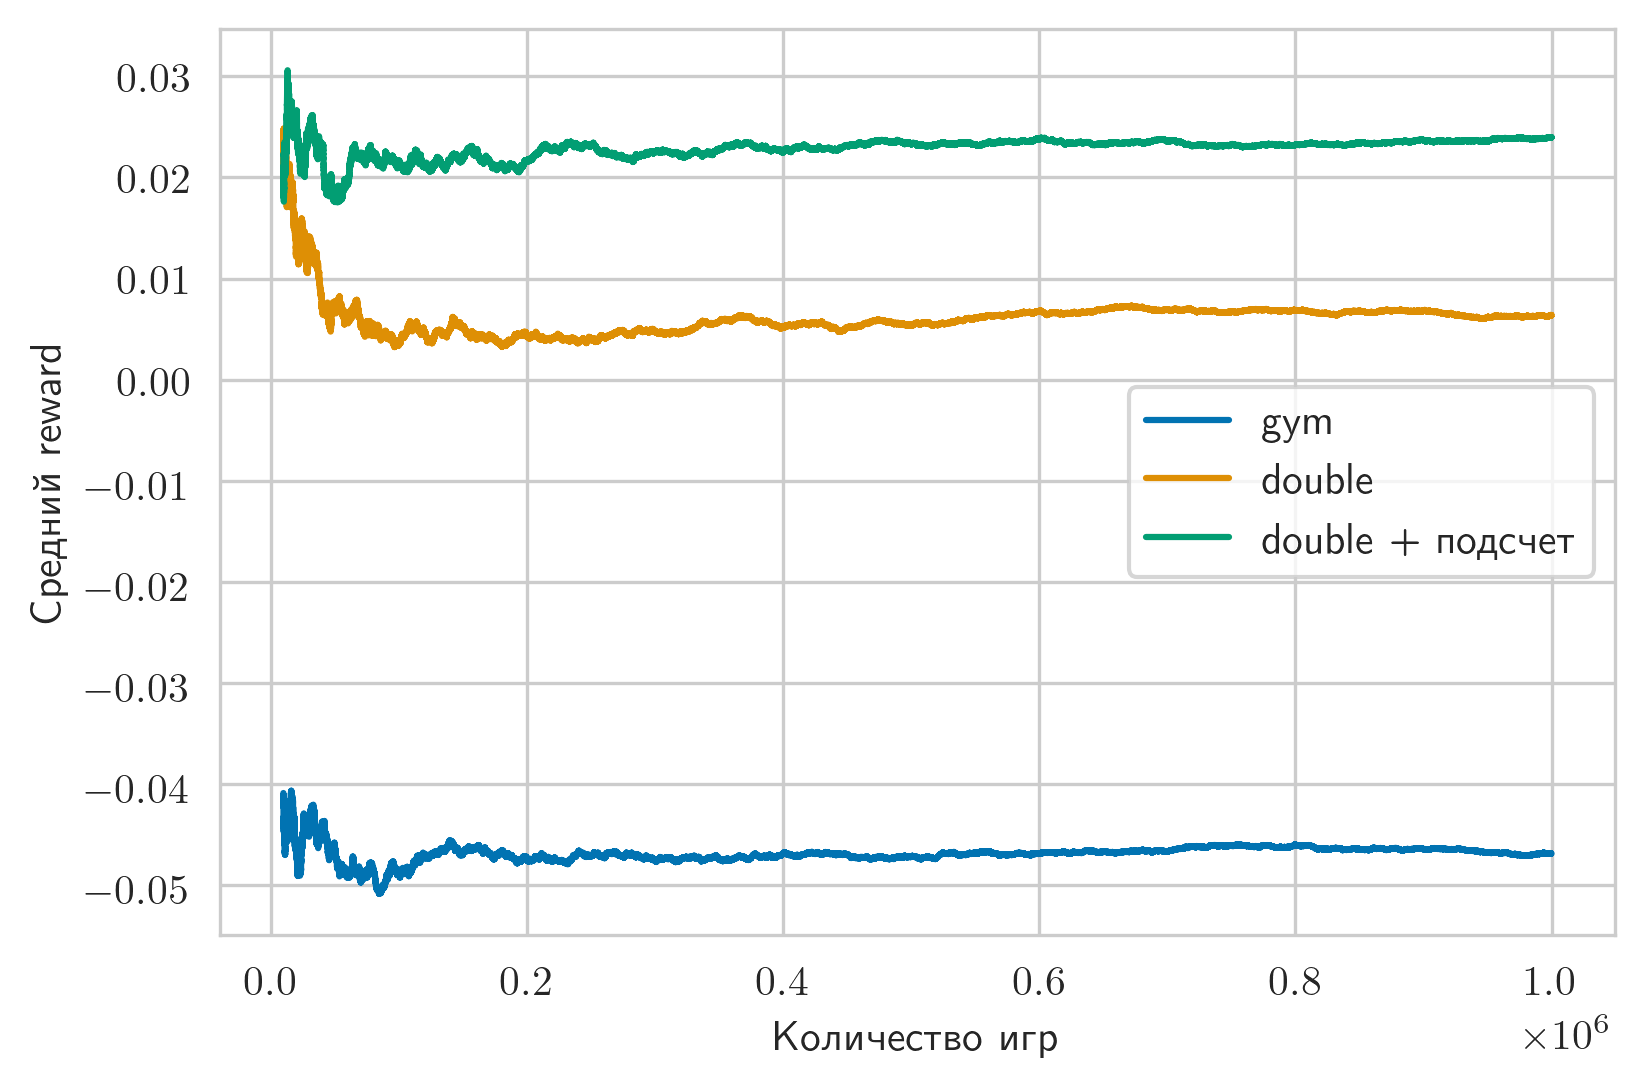

In [59]:
for reward, label in zip([best_Q_strategy_rewards_1, best_Q_strategy_rewards_2, best_Q_strategy_rewards_3],
                         ['gym', 'double', 'double + подсчет']):
    plt.plot(range(10000, len(reward)), reward[10000:], label=label)
plt.ylabel("Средний reward")
plt.xlabel("Количество игр")
plt.legend()

У двух моделей положительный средний reward за 1кк игр, то есть они обыгрывают казино